To convert ruby code to ruby bytecode/iseq instructions, ruby code has to go through the scanner and parser. We'll look at the data structures that the ruby scanner and parser creates. 

In [ ]:
require 'ripper' # ripper is a ruby library that can split code into tokens and build an abstract syntax tree.

## Tokenizing ruby source code

In [ ]:
code = <<STR
a+='hello'
STR

In [ ]:
tokens = Ripper.lex code

tokens.each do |tok| 
  print "#{tok}\n" 
end 

Ripper accepts incorrect ruby code

In [ ]:
bad_code = <<STR
a = kdkdkdkd
print "
STR

In [ ]:
bad_tokens = Ripper.lex bad_code

bad_tokens.each do |tok| 
  print "#{tok}\n" 
end 

Scanners don't have enough information to determine if code is syntactically correct or not

## Tokens to Abstract Syntax Trees

One of the more interesting data structures that the frontend compilation produces is Abstract Syntax Trees. AST represents the structure of the code. Let's look at how ruby creates an AST from a list of tokens. We'll continue using the code samples above.

In [ ]:
code = <<STR
a = 1
b = 2
c = a + b
print c
STR
print "CODE\n#{code}\n"

ast = Ripper.sexp code

If we were to represent this to a tree, it would look something like the following:
![tree](sample_code_tree.png)
     

In [ ]:
root = RubyVM::AbstractSyntaxTree.parse(code)
root.children.last.children

In [ ]:
root.children.last.children[0].children

ASTs are useful in determining for syntax, type and style correctness. 

Ruby 1.8 would take in an AST and execute the instructions directly. As you can see, ASTs can have a large memory footprint as the size of the code gets bigger. Ruby 1.8 interpreter could take a long time to traverse nodes. The nodes may not live closely with one another in the heap.

To reduce memory footprint, ruby 1.9+ converts an AST to bytecode/ISeq. Bytecode can fit in 1 operation for every 1 byte. By adding bytecode generation, we've sacrificed simplicity with completexity and speed. 

## Ruby Interpreter
Let's take a look at what ruby bytecode looks like

In [6]:
options = RubyVM::InstructionSequence.compile_option
options[:inline_const_cache] = false
options[:peephole_optimization] = false
options[:specialized_instruction] = false
options[:operands_unification] = false
options[:coverage_enabled] = false

inseq = RubyVM::InstructionSequence.compile(code, **options)
pp inseq.to_binary # not very useful for us

"YARB\x02\x00\x00\x00\a\x00\x00\x00T\x01\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x0E\x00\x00\x00\xD0\x00\x00\x00\x1C\x01\x00\x00arm64-darwin21\x00%\x05\x05\v\x01%\a\x05\t\x01\x03\v\x01\x03\t\x01e\x00\x00\xFF\xFF\xFF\xFF\xFF\xFF\xFF\xFF\x05\a\x01#\x03\a\x01e\x00\x00\xFF\xFF\xFF\xFF\xFF\xFF\xFF\xFFw\x03\x03\x03\x01\x05\x03\x05\x01\a\x03\a\x01\t\x03\t\x01\x01\x05\a\x05\a\a\x13\x03\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x00\x00\x00\x00\x00\x06\x00\x00\x00\x00\x00\x00\x00\x0F!\x03\x11)\x03\x01=\xD7]\x01\x01\x01\x01\x01\x01\x01\x01{\x01\x03\x03\x03\a!\x03\x01\t\x0F{[\x11=\x01\r\x00\xFF\xFF\xFF\xFF\xFF\xFF\xFF\xFF\x01\r\x01\a\x01\x05\x01\x05\x01\x00\x00\x00\x9E\x00\x00\x00\xF1\x11\x00\x00E\x05\x15<compiled>\x00\x00\x00\xF5\a\x00\x00\xF5\v\x00\x00\x14\x13\x00\x00\x14\x15\x00\x00\x14\x17\x00\x00\x14\x19\x00\x00\x14\e\x00\x00E\x05\x03aE\x05\x03bE\x05\x03cE\x05\x03+E\x05\vprint\xD4\x00\x00\x00\xD8\x00\x00\x00\xE8\x00\x00\x00\xEC\x00\x00\x00\xF0\x00\x00\x00\xF4\x00

"YARB\x02\x00\x00\x00\a\x00\x00\x00T\x01\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x0E\x00\x00\x00\xD0\x00\x00\x00\x1C\x01\x00\x00arm64-darwin21\x00%\x05\x05\v\x01%\a\x05\t\x01\x03\v\x01\x03\t\x01e\x00\x00\xFF\xFF\xFF\xFF\xFF\xFF\xFF\xFF\x05\a\x01#\x03\a\x01e\x00\x00\xFF\xFF\xFF\xFF\xFF\xFF\xFF\xFFw\x03\x03\x03\x01\x05\x03\x05\x01\a\x03\a\x01\t\x03\t\x01\x01\x05\a\x05\a\a\x13\x03\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x00\x00\x00\x00\x00\x06\x00\x00\x00\x00\x00\x00\x00\x0F!\x03\x11)\x03\x01=\xD7]\x01\x01\x01\x01\x01\x01\x01\x01{\x01\x03\x03\x03\a!\x03\x01\t\x0F{[\x11=\x01\r\x00\xFF\xFF\xFF\xFF\xFF\xFF\xFF\xFF\x01\r\x01\a\x01\x05\x01\x05\x01\x00\x00\x00\x9E\x00\x00\x00\xF1\x11\x00\x00E\x05\x15<compiled>\x00\x00\x00\xF5\a\x00\x00\xF5\v\x00\x00\x14\x13\x00\x00\x14\x15\x00\x00\x14\x17\x00\x00\x14\x19\x00\x00\x14\e\x00\x00E\x05\x03aE\x05\x03bE\x05\x03cE\x05\x03+E\x05\vprint\xD4\x00\x00\x00\xD8\x00\x00\x00\xE8\x00\x00\x00\xEC\x00\x00\x00\xF0\x00\x00\x00\xF4\x00

In [ ]:
inseq.eval

In [ ]:
puts inseq.disasm # the disassembled bytecode varies depending on the optimization flags you pass in

If we want to compile with all optimization flags on, this is what we would get: 

In [7]:
optimized_bytecode = RubyVM::InstructionSequence.compile(code)
puts optimized_bytecode.disasm

== disasm: #<ISeq:<compiled>@<compiled>:1 (1,0)-(4,7)> (catch: FALSE)
local table (size: 3, argc: 0 [opts: 0, rest: -1, post: 0, block: -1, kw: -1@-1, kwrest: -1])
[ 3] a@0        [ 2] b@1        [ 1] c@2
0000 putobject_INT2FIX_1_                                             (   1)[Li]
0001 setlocal_WC_0                          a@0
0003 putobject                              2                         (   2)[Li]
0005 setlocal_WC_0                          b@1
0007 getlocal_WC_0                          a@0                       (   3)[Li]
0009 getlocal_WC_0                          b@1
0011 opt_plus                               <calldata!mid:+, argc:1, ARGS_SIMPLE>
0013 setlocal_WC_0                          c@2
0015 putself                                                          (   4)[Li]
0016 getlocal_WC_0                          c@2
0018 opt_send_without_block                 <calldata!mid:print, argc:1, FCALL|ARGS_SIMPLE>
0020 leave


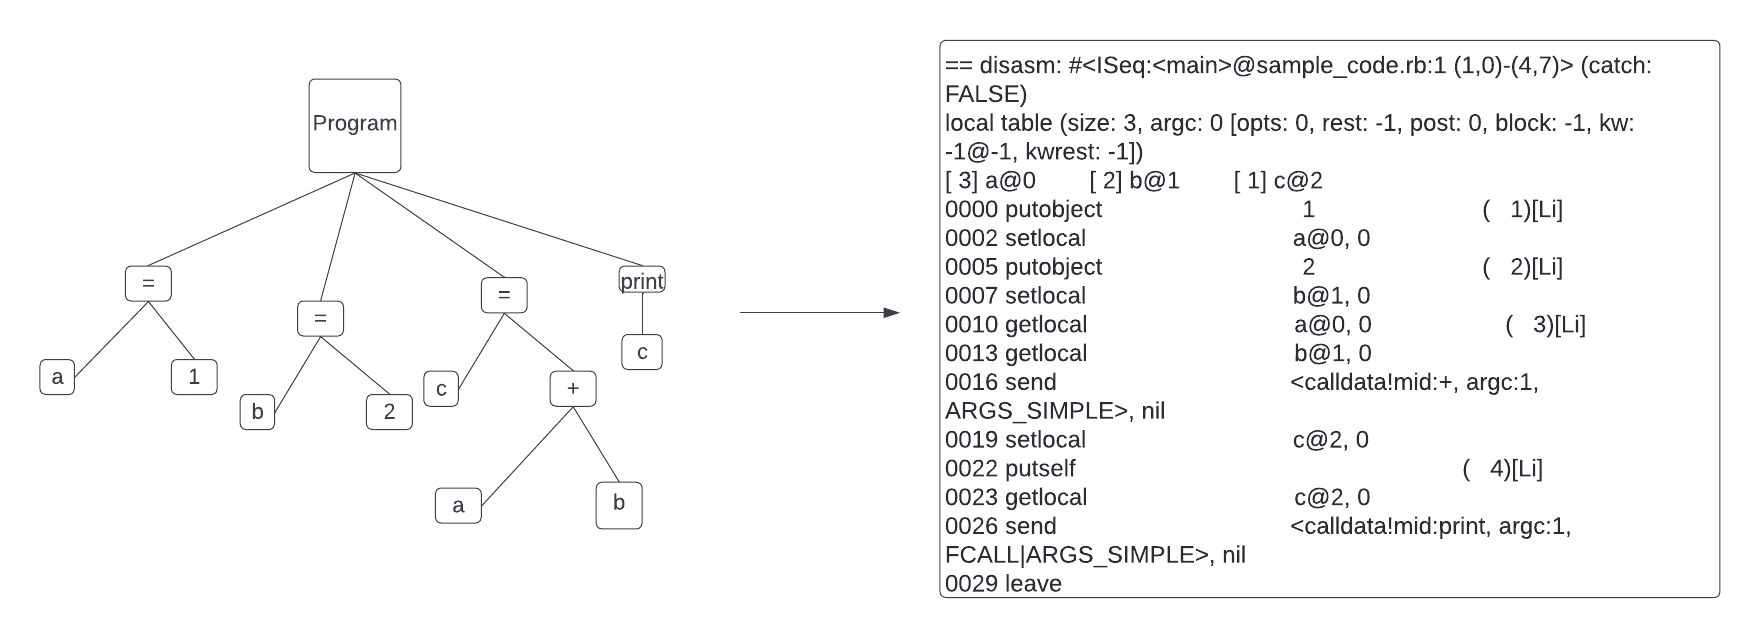

In [ ]:
inseq.to_a.each {|seq| print "#{seq}\n"}

Ruby interpreter uses a stack to keep track of the operations, arguments and return values. 

In [8]:
inseq.to_a[13].each {|x| 
  if x.instance_of?(Array)
    pp x
  else 
    puts x
  end
}

1
RUBY_EVENT_LINE
[:putobject, 1]
[:setlocal, 5, 0]
2
RUBY_EVENT_LINE
[:putobject, 2]
[:setlocal, 4, 0]
3
RUBY_EVENT_LINE
[:getlocal, 5, 0]
[:getlocal, 4, 0]
[:send, {:mid=>:+, :flag=>16, :orig_argc=>1}, nil]
[:setlocal, 3, 0]
4
RUBY_EVENT_LINE
[:putself]
[:getlocal, 3, 0]
[:send, {:mid=>:print, :flag=>20, :orig_argc=>1}, nil]
[:leave]


[1, :RUBY_EVENT_LINE, [:putobject, 1], [:setlocal, 5, 0], 2, :RUBY_EVENT_LINE, [:putobject, 2], [:setlocal, 4, 0], 3, :RUBY_EVENT_LINE, [:getlocal, 5, 0], [:getlocal, 4, 0], [:send, {:mid=>:+, :flag=>16, :orig_argc=>1}, nil], [:setlocal, 3, 0], 4, :RUBY_EVENT_LINE, [:putself], [:getlocal, 3, 0], [:send, {:mid=>:print, :flag=>20, :orig_argc=>1}, nil], [:leave]]

In [ ]:
inseq.to_a

Ruby has a rich set of expressions such as classes, function blocks and simple ruby code. Bytecode for function blocks and classes are different from simple ruby code. 

API doc: https://ruby-doc.org/core-2.6/RubyVM/InstructionSequence.html

In [9]:
_magic, _major_version, _minor_version, _format_type, _misc,
  @name, @path, @absolute_path, @start_lineno, @type,
  @locals, @fargs_format, catch_table, insns = *inseq


["YARVInstructionSequence/SimpleDataFormat", 2, 7, 1, {:arg_size=>0, :local_size=>3, :stack_max=>2, :node_id=>16, :code_location=>[1, 0, 4, 7]}, "<compiled>", "<compiled>", "<compiled>", 1, :top, [:a, :b, :c], {}, [], [1, :RUBY_EVENT_LINE, [:putobject, 1], [:setlocal, 5, 0], 2, :RUBY_EVENT_LINE, [:putobject, 2], [:setlocal, 4, 0], 3, :RUBY_EVENT_LINE, [:getlocal, 5, 0], [:getlocal, 4, 0], [:send, {:mid=>:+, :flag=>16, :orig_argc=>1}, nil], [:setlocal, 3, 0], 4, :RUBY_EVENT_LINE, [:putself], [:getlocal, 3, 0], [:send, {:mid=>:print, :flag=>20, :orig_argc=>1}, nil], [:leave]]]

To load compile bytecode in memory. 

In [24]:
RubyVM::InstructionSequence.load_from_binary(File.binread('binary_data/assign1')).disasm

RuntimeError: unmatched version file (3.0 for 2.7)

we'll be using this Struct to parse the ruby instruction sequences. 

In [11]:
Insn = Struct.new(:insn, :operands, :lineno) # typeprof

#<Class:0x000000013818a6a8>

In [14]:
ninsns = []
lineno = 0
insns.each do |e|
  case e
  when Integer # lineno
    lineno = e
  when Symbol # label or trace
    ninsns << e
  when Array  
    insn, *operands = e
    ninsns << Insn.new(insn, operands, lineno)
  else
    raise "unknown iseq entry: #{ e }"
  end
end

[1, :RUBY_EVENT_LINE, [:putobject, 1], [:setlocal, 5, 0], 2, :RUBY_EVENT_LINE, [:putobject, 2], [:setlocal, 4, 0], 3, :RUBY_EVENT_LINE, [:getlocal, 5, 0], [:getlocal, 4, 0], [:send, {:mid=>:+, :flag=>16, :orig_argc=>1}, nil], [:setlocal, 3, 0], 4, :RUBY_EVENT_LINE, [:putself], [:getlocal, 3, 0], [:send, {:mid=>:print, :flag=>20, :orig_argc=>1}, nil], [:leave]]

In [15]:
puts ninsns

RUBY_EVENT_LINE
#<struct insn=:putobject, operands=[1], lineno=1>
#<struct insn=:setlocal, operands=[5, 0], lineno=1>
RUBY_EVENT_LINE
#<struct insn=:putobject, operands=[2], lineno=2>
#<struct insn=:setlocal, operands=[4, 0], lineno=2>
RUBY_EVENT_LINE
#<struct insn=:getlocal, operands=[5, 0], lineno=3>
#<struct insn=:getlocal, operands=[4, 0], lineno=3>
#<struct insn=:send, operands=[{:mid=>:+, :flag=>16, :orig_argc=>1}, nil], lineno=3>
#<struct insn=:setlocal, operands=[3, 0], lineno=3>
RUBY_EVENT_LINE
#<struct insn=:putself, operands=[], lineno=4>
#<struct insn=:getlocal, operands=[3, 0], lineno=4>
#<struct insn=:send, operands=[{:mid=>:print, :flag=>20, :orig_argc=>1}, nil], lineno=4>
#<struct insn=:leave, operands=[], lineno=4>


In [16]:
self.send(:print, 1)

1

In [17]:
@locals

[:a, :b, :c]

In [ ]:
puts iseq.disasm

### If/Else

In [21]:
iseq_cond = RubyVM::InstructionSequence.compile_file('sample_code/simple_condition.rb', **options)

<RubyVM::InstructionSequence:<main>@sample_code/simple_condition.rb:1>

In [ ]:
puts iseq_func.disasm

In [22]:
_magic, _major_version, _minor_version, _format_type, _misc,
  @name, @path, @absolute_path, @start_lineno, @type,
  @locals, @fargs_format, catch_table, insns = *iseq_func.to_a

["YARVInstructionSequence/SimpleDataFormat", 2, 7, 1, {:arg_size=>0, :local_size=>1, :stack_max=>2, :node_id=>15, :code_location=>[1, 0, 7, 3]}, "<main>", "sample_code/simple_condition.rb", "/Users/macmania/workspace/ruby-bytecode-workshop/sample_code/simple_condition.rb", 1, :top, [:x], {}, [], [1, :RUBY_EVENT_LINE, [:putobject, 5], [:setlocal, 3, 0], 3, :RUBY_EVENT_LINE, [:getlocal, 3, 0], [:putobject, 20], [:send, {:mid=>:<, :flag=>16, :orig_argc=>1}, nil], [:branchunless, :label_25], [:jump, :label_17], :label_17, 4, :RUBY_EVENT_LINE, [:putself], [:putstring, "less than 20"], [:send, {:mid=>:pp, :flag=>20, :orig_argc=>1}, nil], 3, [:jump, :label_31], :label_25, 6, :RUBY_EVENT_LINE, [:putself], [:putstring, "greater than 20"], [:send, {:mid=>:pp, :flag=>20, :orig_argc=>1}, nil], :label_31, [:leave]]]

In [23]:
ninsns = []
lineno = 0
insns.each do |e|
  case e
  when Integer # lineno
    lineno = e
  when Symbol # label or trace
    ninsns << e
  when Array  
    insn, *operands = e
    ninsns << Insn.new(insn, operands, lineno)
  else
    raise "unknown iseq entry: #{ e }"
  end
end

[1, :RUBY_EVENT_LINE, [:putobject, 5], [:setlocal, 3, 0], 3, :RUBY_EVENT_LINE, [:getlocal, 3, 0], [:putobject, 20], [:send, {:mid=>:<, :flag=>16, :orig_argc=>1}, nil], [:branchunless, :label_25], [:jump, :label_17], :label_17, 4, :RUBY_EVENT_LINE, [:putself], [:putstring, "less than 20"], [:send, {:mid=>:pp, :flag=>20, :orig_argc=>1}, nil], 3, [:jump, :label_31], :label_25, 6, :RUBY_EVENT_LINE, [:putself], [:putstring, "greater than 20"], [:send, {:mid=>:pp, :flag=>20, :orig_argc=>1}, nil], :label_31, [:leave]]

In [ ]:
puts ninsns

### Loops